In [1]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Rectangle

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings
import cv2 # by pip install opencv-python

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# # set fonts configuration - Arial
# matplotlib.rcParams['font.family'] = "Open Sans"
# matplotlib.rcParams['font.sans-serif'] = "Arial"

In [4]:
def coordinates_processors(data):
    """
    converting longitude/latitude into lon/lat
    data: xarray.dataset coordinated horizontally in lat/lon
    """

    coord_names = []
    for coord_name in data.coords:
        coord_names.append(coord_name)

    if (set(coord_names) & set(['lon','lat'])): # if coordinates set this way...

        data2 = data.rename({'lat': 'latitude'})
        data2 = data2.rename({'lon': 'longitude'})

    else:
        data2 = data

    # check if lon from -180
    if data2.longitude[0] != 0: # -180 to 180

        lon_reset = data2.longitude
        lon_reset = lon_reset.where(lon_reset > 0, 360+lon_reset) # converting lon as 0 to 359.75
        data2.coords['longitude'] = lon_reset # converting lon as -180 to 180
        data2= data2.sortby('longitude')

    # check if latitutde is decreasing
    if (data2.latitude[1] - data2.latitude[0]) < 0:
        data2 = data2.isel(latitude=slice(None, None, -1)) # flipping latitude accoordingly

    return data2

In [5]:
def process_data_fid_update(data_fid_mask, front_replace=False):
    
    """ updating the origional FID data by adding DC and CG
        set front_replace = True to replace FT and FT-associated labels over the tropics
        input: data_fid_mask (time, lat, lon), feat_comb_label
    """

    data_fid_label = data_fid_mask.feat_comb_label
    data_dc_mask = data_fid_mask.deep_conv_mask # (0,1)
    data_cg_mask = data_fid_mask.nondeep_conv_mask + 1 # now is (1,2) 2 indicates cg_mask = true
    data_anvil_mask = data_fid_mask.anvil_mask + 2     # (2,3), 3 indicates "" 
    data_shallow_mask = data_fid_mask.shallow_mask + 3 # (3,4)
        
    data_dc_label = data_dc_mask.where((data_dc_mask == 1) & (data_fid_label == 16), 0)
    data_cg_label = data_cg_mask.where((data_cg_mask == 2) & (data_fid_label == 16), 0)
    data_anvil_label = data_anvil_mask.where((data_anvil_mask == 3) & (data_fid_label == 16), 0)
    data_shallow_label = data_shallow_mask.where((data_shallow_mask == 4) & (data_fid_label == 16), 0)        

    data_fid_final = (data_fid_label + data_dc_label + data_cg_label + 
                      data_anvil_label + data_shallow_label) # now ranges from 1 to 20
    
    return data_fid_final

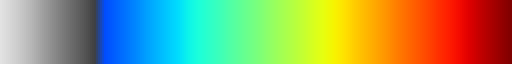

In [6]:
colors1 = plt.cm.Greys(np.linspace(0.2, 0.8, 10))
colors2 = plt.cm.jet(np.linspace(0.2, 1, 40))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mixedmap = LinearSegmentedColormap.from_list('my_colormap', colors)
mixedmap

In [7]:
%%time 

year = 2019

data_dir = Path('/neelin2020/RGMA_feature_mask/data_product/{}/MERGED_FP'.format(year))

# load individual masks and gpm precipitation
files = sorted(list(data_dir.glob('GPM_feature_merged_*_v4.nc')))
data_fid = xr.open_mfdataset(files)
data_mcs = data_fid.mcs_tag
data_ar = data_fid.ar_tag
data_lps = data_fid.lps_tag
data_gpm = data_fid.precipitationCal

# load origional front masks
ft_dir = Path('/neelin2020/RGMA_feature_mask/data_product/{}/Front'.format(year))
files = sorted(list(ft_dir.glob('Front_cold_ERA5feature_mask_{}_*_6hrly.compress.nc'.format(year))))
data_front_c = xr.open_mfdataset(files).fronts.sel(latitude=slice(-60,60))
data_front_c = coordinates_processors(data_front_c)
files = sorted(list(ft_dir.glob('Front_warm_ERA5feature_mask_{}_*_6hrly.compress.nc'.format(year))))
data_front_w = xr.open_mfdataset(files).fronts.sel(latitude=slice(-60,60))
data_front_w = coordinates_processors(data_front_w)
files = sorted(list(ft_dir.glob('Front_stat_ERA5feature_mask_{}_*_6hrly.compress.nc'.format(year))))
data_front_s = xr.open_mfdataset(files).fronts.sel(latitude=slice(-60,60))
data_front_s = coordinates_processors(data_front_s)

# load feature-associated precipitation
files = sorted(list(data_dir.glob('FeatureOverlap_indicator_map_*_v4.nc')))
data_fid = xr.open_mfdataset(files)
data_fid_update = process_data_fid_update(data_fid)

CPU times: user 1.47 s, sys: 346 ms, total: 1.81 s
Wall time: 5.4 s


In [8]:
# load elevation data
data_elev = xr.open_dataset('/neelin2020/RGMA_feature_mask/data_product/multi_year_stats/elev.0.25-deg.nc')
elev = data_elev.data.isel(time=0) # (meter)

In [9]:
FIG_DIR = Path('/neelin2020/RGMA_feature_mask/analysis/figs/animation_figs')

In [10]:
def plot_precipitation_feature(timestamp, fig_save=False, fig_dir=None):
    
    data_gpm_sel = data_gpm.sel(time=timestamp)
    data_gpm_sel = data_gpm_sel.where(data_gpm_sel > 0)
    data_mcs_sel = data_mcs.sel(time=timestamp)
    data_mcs_sel = data_mcs_sel.where(data_mcs_sel > 0)
    data_ar_sel = data_ar.sel(time=timestamp)
    data_ar_sel = data_ar_sel.where(data_ar_sel > 0)
    data_ftc_sel = data_front_c.sel(time=timestamp)
    data_ftc_sel = data_ftc_sel.where(data_ftc_sel > 0)
    data_ftw_sel = data_front_w.sel(time=timestamp)
    data_ftw_sel = data_ftw_sel.where(data_ftw_sel > 0)
    data_fts_sel = data_front_s.sel(time=timestamp)
    data_fts_sel = data_fts_sel.where(data_fts_sel > 0)
    data_lps_sel = data_lps.sel(time=timestamp)
    data_lps_sel = data_lps_sel.where(data_lps_sel > 0)    
    
    fig, ax = plt.subplots(1,1,figsize=(12,4),subplot_kw={'projection': ccrs.Robinson(180)})
    ax.coastlines(resolution='50m', color='k',linewidth=0.5)
    ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) # maskout LAND
    ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
    ax.add_feature(cfeat.STATES,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.25) 

    # plot feature masks
    ax.contourf(data_mcs_sel.longitude, data_mcs_sel.latitude, data_mcs_sel, cmap=ListedColormap(['olivedrab']), 
               alpha=0.5, transform=ccrs.PlateCarree(), zorder=2) # mcs
    ax.contourf(data_lps_sel.longitude, data_lps_sel.latitude, data_lps_sel, cmap=ListedColormap(['r']), 
               alpha=0.3, transform=ccrs.PlateCarree(), zorder=2) # lps
    ax.contourf(data_ar_sel.longitude, data_ar_sel.latitude, data_ar_sel, cmap=ListedColormap(['skyblue']), 
               alpha=0.5, transform=ccrs.PlateCarree(), zorder=2) # ar
    ax.pcolormesh(data_ftc_sel.longitude, data_ftc_sel.latitude, data_ftc_sel, cmap=ListedColormap(['navy']), 
               transform=ccrs.PlateCarree(), zorder=3) # cold front
    ax.pcolormesh(data_ftw_sel.longitude, data_ftw_sel.latitude, data_ftw_sel, cmap=ListedColormap(['r']), 
               transform=ccrs.PlateCarree(), zorder=3) # warm front
    ax.pcolormesh(data_fts_sel.longitude, data_fts_sel.latitude, data_fts_sel, cmap=ListedColormap(['chocolate']), 
               transform=ccrs.PlateCarree(), zorder=3) # stationary front

    #plot gpm precipitation
    cp = ax.pcolormesh(data_gpm_sel.longitude, data_gpm_sel.latitude,
                       data_gpm_sel, vmin=0, vmax=8, cmap=mixedmap, transform=ccrs.PlateCarree(),zorder=1)
    cbar = plt.colorbar(cp,ax=ax, pad=0.01, shrink=0.8)
    cbar.set_label('(mm hr$^{-1}$)',fontsize=10)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0, color='gray', alpha=0.4, linestyle=':')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size':9}
    gl.ylabel_style = {'size':9}

    # add feature mask legend
    legend_elements = [Patch(facecolor='skyblue', edgecolor=None, alpha=0.5,
                             label='AR'),
                       Patch(facecolor='olivedrab', edgecolor=None, alpha=0.5,
                             label='MCS'),
                       Patch(facecolor='red', edgecolor=None, alpha=0.3,
                             label='LPS'),
                       Line2D([1], [1], color='navy', lw=3, label='Cold front'),
                       Line2D([1], [1], color='r', lw=3, label='Warm front'),
                       Line2D([1], [1], color='chocolate', lw=3, label='Stat. front')]

    ax.legend(handles=legend_elements, loc='center', ncols=6, bbox_to_anchor=(0.5, 1.1)
              ,frameon=False, prop={'weight':'bold'})
    ax.set_title('Global Precipitation Map & Atmospheric Features \n' + '{}'.format(str(data_gpm_sel.time.values)[:13])
                 , fontsize=11, y=1.15, fontweight='bold');
    
    if fig_save == True:
        fig.savefig(fig_dir / 'precip_features_{}.png'.format(str(data_gpm_sel.time.values)[:13]),
                    dpi=600 ,bbox_inches='tight', transparent=False)
        print('{}'.format(str(data_gpm_sel.time.values)[:13]))
        plt.close()
        
    return fig, ax

In [22]:
def plot_precipitation_feature_regional(timestamp, lon_sel, lat_sel, fig_save=False, fig_dir=None):
    
    data_gpm_sel = data_gpm.sel(time=timestamp, latitude=slice(lat_sel[0],lat_sel[1]), longitude=slice(lon_sel[0],lon_sel[1]))
    data_gpm_sel = data_gpm_sel.where(data_gpm_sel > 0)
    data_mcs_sel = data_mcs.sel(time=timestamp, latitude=slice(lat_sel[0],lat_sel[1]), longitude=slice(lon_sel[0],lon_sel[1]))
    data_mcs_sel = data_mcs_sel.where(data_mcs_sel > 0)
    data_ar_sel = data_ar.sel(time=timestamp, latitude=slice(lat_sel[0],lat_sel[1]), longitude=slice(lon_sel[0],lon_sel[1]))
    data_ar_sel = data_ar_sel.where(data_ar_sel > 0)
    data_ftc_sel = data_front_c.sel(time=timestamp, latitude=slice(lat_sel[0],lat_sel[1]), longitude=slice(lon_sel[0],lon_sel[1]))
    data_ftc_sel = data_ftc_sel.where(data_ftc_sel > 0)
    data_ftw_sel = data_front_w.sel(time=timestamp, latitude=slice(lat_sel[0],lat_sel[1]), longitude=slice(lon_sel[0],lon_sel[1]))
    data_ftw_sel = data_ftw_sel.where(data_ftw_sel > 0)
    data_fts_sel = data_front_s.sel(time=timestamp, latitude=slice(lat_sel[0],lat_sel[1]), longitude=slice(lon_sel[0],lon_sel[1]))
    data_fts_sel = data_fts_sel.where(data_fts_sel > 0)
    data_lps_sel = data_lps.sel(time=timestamp, latitude=slice(lat_sel[0],lat_sel[1]), longitude=slice(lon_sel[0],lon_sel[1]))
    data_lps_sel = data_lps_sel.where(data_lps_sel > 0)    
    
    fig, ax = plt.subplots(1,1,figsize=(6,6),subplot_kw={'projection': ccrs.PlateCarree(180)})
    ax.coastlines(resolution='50m',zorder=3,color='k',linewidth=0.5)
    ax.add_feature(cfeat.LAND,zorder=3,edgecolor='k',facecolor='none',linewidth=0.4) # maskout LAND
    ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='k',facecolor='none',linewidth=0.4)
    ax.add_feature(cfeat.STATES,zorder=3,edgecolor='k',facecolor='none',linewidth=0.4)

    # plot feature masks
    ax.pcolormesh(data_mcs_sel.longitude, data_mcs_sel.latitude, data_mcs_sel, cmap=ListedColormap(['olivedrab']), 
               alpha=0.5, transform=ccrs.PlateCarree(), zorder=2) # mcs
    ax.pcolormesh(data_lps_sel.longitude, data_lps_sel.latitude, data_lps_sel, cmap=ListedColormap(['r']), 
               alpha=0.3, transform=ccrs.PlateCarree(), zorder=2) # lps
    ax.pcolormesh(data_ar_sel.longitude, data_ar_sel.latitude, data_ar_sel, cmap=ListedColormap(['skyblue']), 
               alpha=0.5, transform=ccrs.PlateCarree(), zorder=2) # ar
    ax.pcolormesh(data_ftc_sel.longitude, data_ftc_sel.latitude, data_ftc_sel, cmap=ListedColormap(['navy']), 
               transform=ccrs.PlateCarree(), zorder=3) # cold front
    ax.pcolormesh(data_ftw_sel.longitude, data_ftw_sel.latitude, data_ftw_sel, cmap=ListedColormap(['r']), 
               transform=ccrs.PlateCarree(), zorder=3) # warm front
    ax.pcolormesh(data_fts_sel.longitude, data_fts_sel.latitude, data_fts_sel, cmap=ListedColormap(['chocolate']), 
               transform=ccrs.PlateCarree(), zorder=3) # stationary front
    
    # add contour to hightlight feature boundaries
    data_ar_con = data_ar.sel(time=timestamp, latitude=slice(lat_sel[0],lat_sel[1]), longitude=slice(lon_sel[0],lon_sel[1]))
    data_mcs_con = data_mcs.sel(time=timestamp, latitude=slice(lat_sel[0],lat_sel[1]), longitude=slice(lon_sel[0],lon_sel[1]))

    ax.contour(data_ar_con.longitude, data_ar_con.latitude, data_ar_con, colors=['k'], 
               transform=ccrs.PlateCarree(), zorder=3, linewidths=0.1) # ar
    ax.contour(data_mcs_con.longitude, data_mcs_con.latitude, data_mcs_con, colors=['k'], 
               transform=ccrs.PlateCarree(), zorder=3, linewidths=0.1) # mcs    
    
    #plot gpm precipitation
    cp = ax.pcolormesh(data_gpm_sel.longitude, data_gpm_sel.latitude,
                       data_gpm_sel, vmin=0, vmax=8, cmap=mixedmap, transform=ccrs.PlateCarree(),zorder=1)
    cbar = plt.colorbar(cp,ax=ax, pad=0.02, shrink=0.7)
    cbar.set_label('precipitation (mm hr$^{-1}$)',fontsize=10)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.4, linestyle=':')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size':9}
    gl.ylabel_style = {'size':9}

    # add feature mask legend
    legend_elements = [Patch(facecolor='skyblue', edgecolor=None, alpha=0.5,
                             label='AR'),
                       Line2D([1], [1], color='navy', lw=3, label='Cold front'),
                       Patch(facecolor='olivedrab', edgecolor=None, alpha=0.5,
                             label='MCS'),
                       Line2D([1], [1], color='r', lw=3, label='Warm front'),
                       Patch(facecolor='red', edgecolor=None, alpha=0.3,
                             label='LPS'),
                       Line2D([1], [1], color='chocolate', lw=3, label='Stat. front')]

    ax.legend(handles=legend_elements, loc='center', ncols=3, bbox_to_anchor=(0.5, 1.1)
              ,frameon=False, prop={'weight':'bold'})
    ax.set_title('GPM-IMERG & Atmospheric Features \n' + '{}'.format(str(data_gpm_sel.time.values)[:13])
                 , fontsize=11, y=1.15, fontweight='bold');
    
    # plot inner box 
    # rect = Rectangle((294.25-180, -33.25), width=2, height=2, fc ='none', ec ='magenta', linewidth=1,
    #                 zorder=2)
    # ax.add_patch(rect)
    
    # add CACTI campaign region
    #ax.text(309-180, 11.3, 'xxx', color='w', 
    #        bbox=dict(facecolor='w', edgecolor='magenta'), fontsize=4)
    #ax.text(312-180, 11, 'CACTI Domain', color='k', 
    #        bbox=dict(facecolor='none', edgecolor='none'), fontsize=10, fontweight='bold')
    lon_cen = (lon_sel[0]+lon_sel[1])/2
    lat_cen = (lat_sel[0]+lat_sel[1])/2
    ax.plot(lon_cen-180, lat_cen, 'x', ms=5, color='r')
    
    if fig_save == True:
        fig.savefig(fig_dir / 'precip_features_{}.png'.format(str(data_gpm_sel.time.values)[:13]),
                    dpi=600 ,bbox_inches='tight', transparent=False)
        print('{}'.format(str(data_gpm_sel.time.values)[:13]))
        plt.close()
        
    return fig, ax

In [23]:
tmp = data_gpm.isel(time=0).compute()
lat_cen = 34.34
lon_cen = 180 + (180-87.34)
deg_width = 10

tmp = tmp.sel(longitude=slice(lon_cen-deg_width,lon_cen+deg_width)
             ,latitude=slice(lat_cen-deg_width,lat_cen+deg_width))
tmp = tmp.where(tmp > 0) # remove zero and replaced with nan

#tmp2 = elev.sel(lon=slice(lon_cen-deg_width,lon_cen+deg_width)
#             ,lat=slice(lat_cen-deg_width,lat_cen+deg_width))

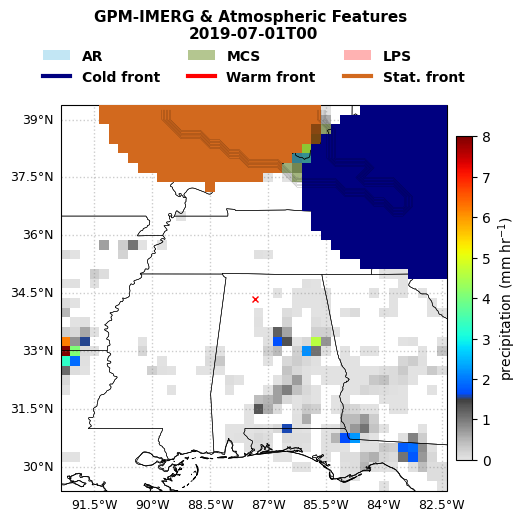

In [24]:
# Outer domain: South America, Inner domain: CACTI campaign region
# 2018-10-01 - 2019-04-30
# 31.25S-33.25S; 65.75W-63.5W

lat_cen = 34.34
lon_cen = 180 + (180-87.34)
deg_width = 5

fig_plt, ax_plt = plot_precipitation_feature_regional(timestamp=datetime(2019,7,1,0),
                                                      lon_sel=[lon_cen-deg_width,lon_cen+deg_width],
                                                      lat_sel=[lat_cen-deg_width,lat_cen+deg_width],
                                                      fig_save=False)
#fig_plt.savefig('/neelin2020/RGMA_feature_mask/analysis/figs/CACTI_figs/precip_feature_CACTI_test.png',
#            dpi=600, bbox_inches='tight', transparent=False)

In [25]:
%%time
time_list = pd.date_range(datetime(2019,12,1,0), datetime(2019,12,31,18), freq='6H')

for t in time_list:
    fig_dir = Path('/neelin2020/RGMA_feature_mask/analysis/figs/ARM_BNF/')
    if fig_dir.exists() == False:
        os.system('mkdir -p {}'.format(fig_dir))
    # CACTI campaign region
    plot_precipitation_feature_regional(timestamp=t,
                                        lon_sel=[lon_cen-deg_width,lon_cen+deg_width],
                                        lat_sel=[lat_cen-deg_width,lat_cen+deg_width],
                                        fig_save=True, fig_dir=fig_dir)

2019-12-01T00
2019-12-01T06
2019-12-01T12
2019-12-01T18
2019-12-02T00
2019-12-02T06
2019-12-02T12
2019-12-02T18
2019-12-03T00
2019-12-03T06
2019-12-03T12
2019-12-03T18
2019-12-04T00
2019-12-04T06
2019-12-04T12
2019-12-04T18
2019-12-05T00
2019-12-05T06
2019-12-05T12
2019-12-05T18
2019-12-06T00
2019-12-06T06
2019-12-06T12
2019-12-06T18
2019-12-07T00
2019-12-07T06
2019-12-07T12
2019-12-07T18
2019-12-08T00
2019-12-08T06
2019-12-08T12
2019-12-08T18
2019-12-09T00
2019-12-09T06
2019-12-09T12
2019-12-09T18
2019-12-10T00
2019-12-10T06
2019-12-10T12
2019-12-10T18
2019-12-11T00
2019-12-11T06
2019-12-11T12
2019-12-11T18
2019-12-12T00
2019-12-12T06
2019-12-12T12
2019-12-12T18
2019-12-13T00
2019-12-13T06
2019-12-13T12
2019-12-13T18
2019-12-14T00
2019-12-14T06
2019-12-14T12
2019-12-14T18
2019-12-15T00
2019-12-15T06
2019-12-15T12
2019-12-15T18
2019-12-16T00
2019-12-16T06
2019-12-16T12
2019-12-16T18
2019-12-17T00
2019-12-17T06
2019-12-17T12
2019-12-17T18
2019-12-18T00
2019-12-18T06
2019-12-18T12
2019-1

### Generate MP4 files

In [26]:
FIG_DIR = Path('/neelin2020/RGMA_feature_mask/analysis/figs/ARM_BNF/')
os.chdir(FIG_DIR)

img_array = []

for filename in sorted(list(FIG_DIR.glob('*-12-*.png'))):
    img = cv2.imread(str(filename))
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
    
out = cv2.VideoWriter('RGMA_feature_precip_ARM_BNF_201912.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 3, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
    
out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [93]:
tmp = xr.open_dataset('/scratch/wmtsai/featenv_analysis/dataset/MCS_FLEXTRKR_tropics/2014/feature_catalogs/track/track_geoinfo.nc')
int(str(tmp.isel(tracks=0).base_time[0].values)[:4])

2014

In [12]:
# load origional front expanded masks
ft_dir = Path('/neelin2020/RGMA_feature_mask/data_product/{}/Front_expand'.format(year))
files = sorted(list(ft_dir.glob('Front_cold_ERA5feature_mask_{}_*_6hrly.compress.nc'.format(year))))
data_front_c = xr.open_mfdataset(files).fronts.sel(latitude=slice(-60,60))
data_front_c = coordinates_processors(data_front_c)
files = sorted(list(ft_dir.glob('Front_warm_ERA5feature_mask_{}_*_6hrly.compress.nc'.format(year))))
data_front_w = xr.open_mfdataset(files).fronts.sel(latitude=slice(-60,60))
data_front_w = coordinates_processors(data_front_w)
files = sorted(list(ft_dir.glob('Front_stat_ERA5feature_mask_{}_*_6hrly.compress.nc'.format(year))))
data_front_s = xr.open_mfdataset(files).fronts.sel(latitude=slice(-60,60))
data_front_s = coordinates_processors(data_front_s)

# get some significant events from the time-series
precip_onsite = data_gpm.sel(latitude=slice(lat_cen-1,lat_cen+1)
                           , longitude=slice(lon_cen-1,lon_cen)).mean(('longitude','latitude'))
ar_onsite = data_ar.sel(latitude=slice(lat_cen-1,lat_cen+1)
                           , longitude=slice(lon_cen-1,lon_cen)).mean(('longitude','latitude'))
mcs_onsite = data_mcs.sel(latitude=slice(lat_cen-1,lat_cen+1)
                           , longitude=slice(lon_cen-1,lon_cen)).mean(('longitude','latitude'))
lps_onsite = data_lps.sel(latitude=slice(lat_cen-1,lat_cen+1)
                           , longitude=slice(lon_cen-1,lon_cen)).mean(('longitude','latitude'))
                           
front_onsite = (data_front_c + data_front_s + data_front_w).sel(latitude=slice(lat_cen-1,lat_cen+1)
                           , longitude=slice(lon_cen-1,lon_cen)).mean(('longitude','latitude'))
front_onsite = front_onsite.where(front_onsite == 0, 1)

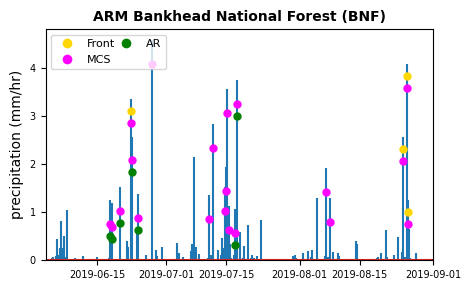

In [36]:
fig, ax = plt.subplots(1,1,figsize=(5,3))
# area-average (+-1 deg. centered at NBF)
#ax.plot(precip_onsite.time[1080:], precip_onsite.values[1080:], color='grey')
ax.stem(precip_onsite.time[612:972], precip_onsite.values[612:972], markerfmt=" ")
# horizontal line for p_mean > 3 mm/hr
#ax.plot(precip_onsite.time[612:972], np.full(len(precip_onsite.time[612:972]), 1), '--r')
ax.set_ylabel('precipitation (mm/hr)',fontsize=10)

#idx_time = np.where(precip_onsite > 1)[0]
for t in idx_time:
    if t >= 612 and t <=972:
        #plt.text(x=precip_onsite.time[t], y=precip_onsite.values[t]
        #       , s='{}'.format(str(precip_onsite.time[t].values)[:13]),fontsize=6)
        if front_onsite.values[t] > 0:
            plt.plot(precip_onsite.time[t], precip_onsite.values[t]-0.25, 'o', color='gold', ms=5)
        if mcs_onsite.values[t] > 0:
            plt.plot(precip_onsite.time[t], precip_onsite.values[t]-0.5, 'o', color='magenta', ms=5)
        if ar_onsite.values[t] > 0:
            plt.plot(precip_onsite.time[t], precip_onsite.values[t]-0.75, 'o', color='g', ms=5)
        #if lps_onsite.values[t] > 0:
        #    plt.plot(precip_onsite.time[t], precip_onsite.values[t]-2, 'ok', ms=6)        

# add feature marks on top of it
#ax.set_xlim([precip_onsite.time[720], precip_onsite.time[-1]])
ax.set_title('ARM Bankhead National Forest (BNF)',fontsize=10,fontweight='bold')
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Front',
                          markerfacecolor='gold', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='MCS',
                          markerfacecolor='magenta', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='AR',
                          markerfacecolor='g', markersize=8),]

ax.tick_params(labelsize=7)
ax.legend(handles=legend_elements, loc='upper left', ncols=2,columnspacing=0,fontsize=8)
ax.set_xlim([precip_onsite.time[612], precip_onsite.time[972]])
ax.set_ylim(ymin=0)
plt.show()
FIG_DIR = Path('/neelin2020/RGMA_feature_mask/analysis/figs/ARM_BNF/')
fig.savefig(FIG_DIR / 'timeseries_precip_featuretags_summer_forDOEporposal.pdf',bbox_inches='tight',transparent=False)